In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns 


from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Adding Apache Spark with Hadoop

In [4]:
!sudo apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,461 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,450 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/res

In [5]:
!pip install pyspark

from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, translate

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 60.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=7e1a7caae5215fe4d5ba6cf69154d5d4bbd5a903a7e2c38abc1573c9f55395f0
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [6]:
# linking with SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName('Twitter').getOrCreate()


In [7]:
df1 = spark.read.load("/content/drive/MyDrive/Project/Corona_NLP_train.csv", format="csv", inferSchema=True, header=True)

In [8]:
df1.head()

Row(UserName='3799', ScreenName='48751', Location='London', TweetAt='16-03-2020', OriginalTweet='@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8', Category='Ambigous')

In [9]:
df1.printSchema()

root
 |-- UserName: string (nullable = true)
 |-- ScreenName: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Category: string (nullable = true)



In [10]:
df1.describe()

DataFrame[summary: string, UserName: string, ScreenName: string, Location: string, TweetAt: string, OriginalTweet: string, Category: string]

In [11]:
df1.count()


68020

In [12]:
df=df1.toPandas()

In [13]:
print(df)

                                  UserName  ...            Category
0                                     3799  ...            Ambigous
1                                     3800  ...            Positive
2                                     3801  ...            Positive
3                                     3802  ...                None
4                                   PLEASE  ...                None
...                                    ...  ...                 ...
68015                                44952  ...  Extremely Negative
68016                                44953  ...            Positive
68017                                44954  ...                None
68018  #coronavirus #COVID19 #coronavirus"  ...                None
68019                                44955  ...            Negative

[68020 rows x 6 columns]


Analysis

In [14]:
train = pd.read_csv('/content/drive/MyDrive/Project/Corona_NLP_test.csv',encoding='latin1')

test = pd.read_csv('/content/drive/MyDrive/Project/Corona_NLP_test.csv',encoding='latin1')

# Combine train and test set
df2 = train.append(test, ignore_index=True)
df = df.append(test, ignore_index=True)

In [15]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Category
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Ambigous
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,None
4,PLEASE,don't panic,THERE WILL BE ENOUGH FOOD FOR EVERYONE if you...,None,None,None


In [16]:
df.isnull().sum()

UserName          3802
ScreenName       16174
Location         38404
TweetAt          30082
OriginalTweet    30435
Category         43197
dtype: int64

In [17]:
df.Category.value_counts()

Positive                                                                                                                                  8665
Negative                                                                                                                                  7900
Ambigous                                                                                                                                  5845
Extremely Positive                                                                                                                        5011
Extremely Negative                                                                                                                        4343
                                                                                                                                          ... 
 mechanics etc still out there too!                                                                                                          1

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75616 entries, 0 to 75615
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       71814 non-null  object
 1   ScreenName     59442 non-null  object
 2   Location       37212 non-null  object
 3   TweetAt        45534 non-null  object
 4   OriginalTweet  45181 non-null  object
 5   Category       32419 non-null  object
dtypes: object(6)
memory usage: 3.5+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


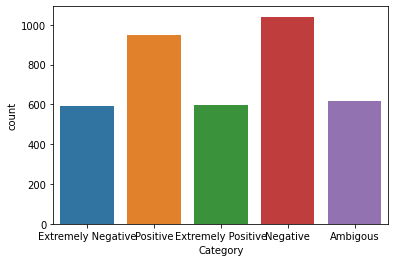

In [19]:
sns.countplot(train['Category'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


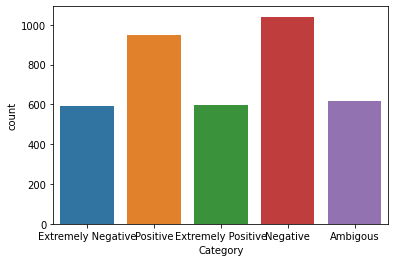

In [20]:
sns.countplot(test['Category'])

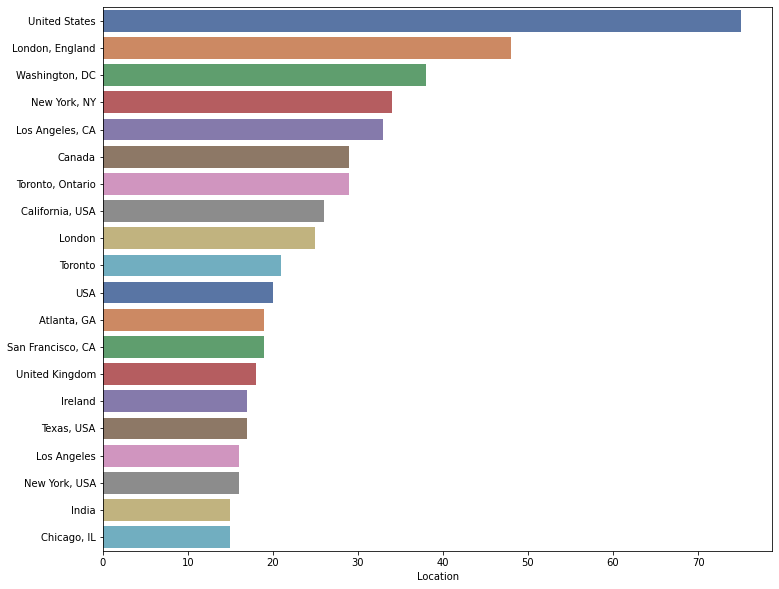

In [21]:
location = train["Location"].value_counts()[:20]
plt.subplots(figsize=(12,10))
sns.barplot(y=location.index, x=location, palette="deep", data=train)

In [22]:
import plotly.express as px
vals = [len(df[df['Category']=='Negative']['Category']), len(df[df['Category']=='Positive']['Category']), len(df[df['Category']=='Ambigous']['Category'])]
idx = ['Negative', 'Positive', 'Ambigous']
fig = px.pie(
    df2,
    names='Category',
    title='Target Value Distribution Chart',
    color_discrete_sequence=px.colors.sequential.Agsunset
)
fig.show()

In [23]:
# Convert Category into Positive/related to medical condition = 2 ,  Ambiguous = 1 , Negative / not related to medical condition =  0
def convert_Sentiment(Category):
    if Category == "Extremely Positive":
        return 2
    elif Category == "Extremely Negative":
        return 0
    elif Category == "Positive":
        return 2
    elif Category == "Negative":
        return 0
    else:
        return 1

In [24]:
# Apply  function
df.Category = df.Category.apply(lambda x : convert_Sentiment(x))

1    49697
2    13676
0    12243
Name: Category, dtype: int64
**********************************************************************


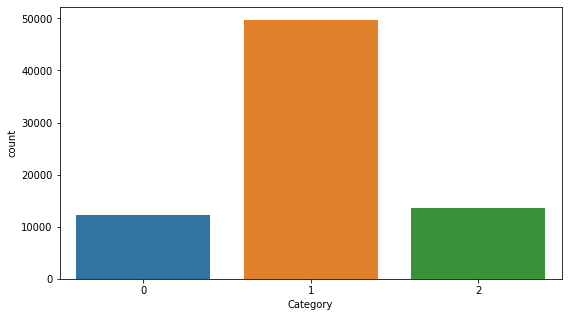

In [25]:
# Visualize 
print(df.Category.value_counts())
print('*' * 70)
plt.figure(figsize = (9,5)) 
sns.countplot(x = 'Category',data = df)
plt.show()

In [26]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", str(s))
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [27]:
# Clean text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# Apply functions on OriginalTweet
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_url(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : remove_emoji(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : decontraction(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : seperate_alphanumeric(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : unique_char(cont_rep_char,x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : char(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x : x.lower())

In [28]:
# Split  groups 
Positive = df[df['Category'] == 2].OriginalTweet
Ambigous  = df[df['Category'] == 1].OriginalTweet
Negative = df[df['Category'] == 0].OriginalTweet

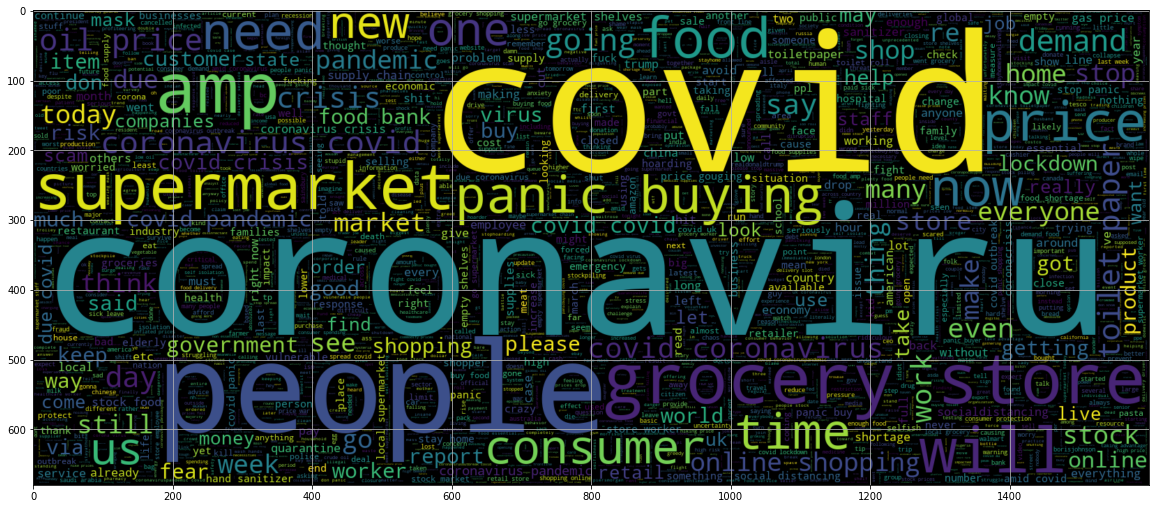

In [29]:
# Worldcould of  Negative Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Negative))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

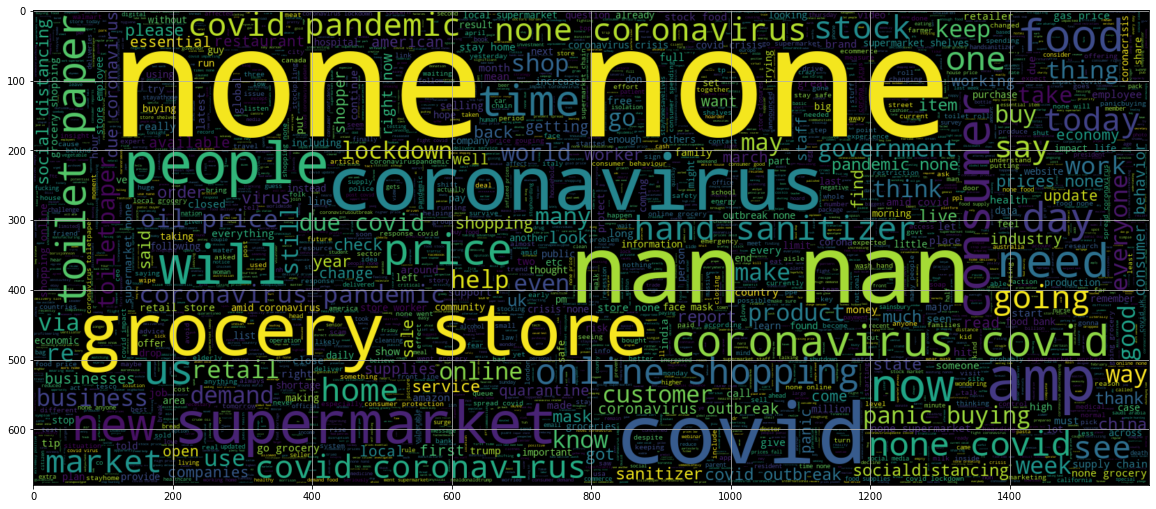

In [30]:
# Wordcould of Neutral Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Ambigous))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

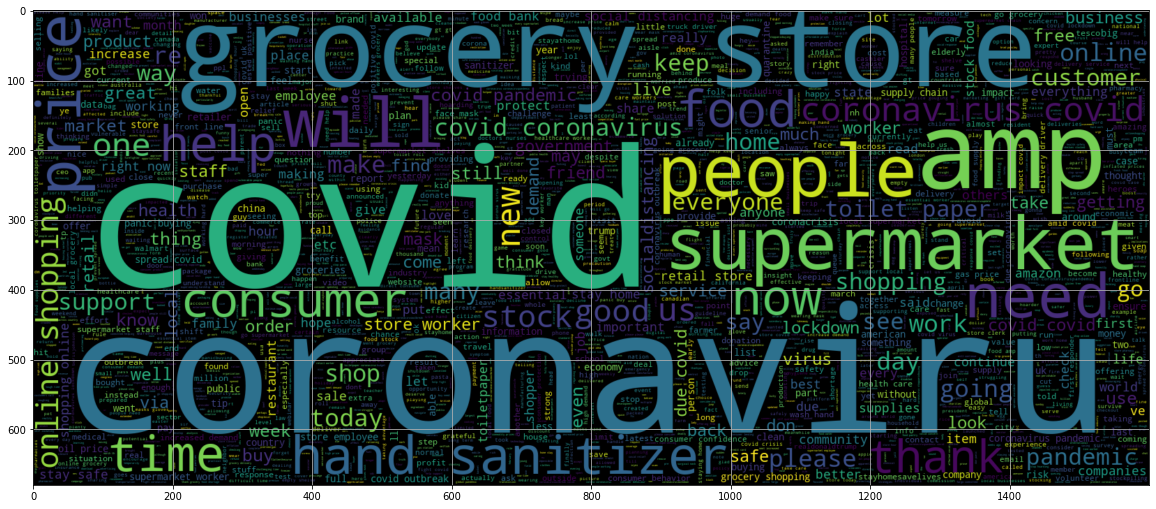

In [31]:
# Wordcould of Positive Tweets 
plt.figure(figsize = (20,20)) 
wordcould = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(Positive))
plt.imshow(wordcould,interpolation = 'bilinear')
plt.grid(None)

In [32]:
X = df['OriginalTweet']
y = df['Category']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [33]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (60492,)
Shape of y_train :  (60492,)
Shape of X_test :  (15124,)
Shape of y_test :  (15124,)


In [34]:
# Convert y to categorical 
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

In [35]:
# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [36]:
# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [37]:
# Create Model  
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

In [38]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
model.fit(X_train_final,y_train, epochs=2,validation_data=(X_test_final,y_test))

Epoch 1/2
1891/1891 [==============================] - 338s 177ms/step - loss: 0.4997 - accuracy: 0.7679 - val_loss: 0.3995 - val_accuracy: 0.8285
Epoch 2/2
1891/1891 [==============================] - 330s 175ms/step - loss: 0.3267 - accuracy: 0.8642 - val_loss: 0.3636 - val_accuracy: 0.8500


In [40]:
# Evaluate
model.evaluate(X_test_final,y_test)

473/473 [==============================] - 16s 33ms/step - loss: 0.3636 - accuracy: 0.8500


[0.3636232614517212, 0.8500396609306335]

In [41]:
# Predict test
lstm_pred = np.round(model.predict(X_test_final))

In [42]:
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      2437
           1       0.95      0.86      0.90      9985
           2       0.73      0.78      0.75      2702

   micro avg       0.86      0.84      0.85     15124
   macro avg       0.79      0.82      0.80     15124
weighted avg       0.87      0.84      0.85     15124
 samples avg       0.84      0.84      0.84     15124



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.tokenize import casual_tokenize


In [44]:
tweets_raw = df['OriginalTweet']
tweets = tweets_raw.apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str(x)))
tweets.head(5)

0                 menyrbie phil gahan chrisitv and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3     my food stock is not the only one which is empty
4                                                 none
Name: OriginalTweet, dtype: object

In [45]:
vectorizer = TfidfVectorizer(lowercase=True,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65)
representation = vectorizer.fit_transform(tweets).toarray()

In [46]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(representation,
                                                 df['Category'])

In [ ]:
logreg_model_check = LogisticRegression(penalty='elasticnet',solver="saga",l1_ratio=0.9,n_jobs=-1).fit(x_train,y_train)


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(logreg_model_check.predict(x_test),y_test))

0.8394874988878014
